In [12]:
%matplotlib inline
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Dataset Statistics

### Distribution of Songs per Year

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116912c50>]],
      dtype=object)

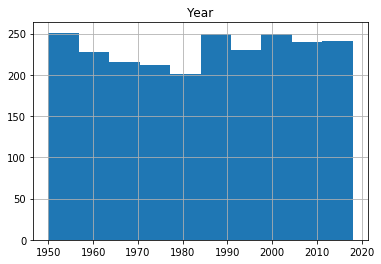

In [4]:
df = pd.read_csv('chords.csv')
df['Chords'] = df['Chords'].str[1:-1].replace("'", '')
df.hist(column='Year')

In [5]:
df.head()

,Artist,Track,Year,Chords
0,Perez Prado And His Orchestra,Patricia,1950,"'Am', 'Am', 'C', 'Dm', 'Em', 'Am', 'C', 'Dm', ..."
1,Bobby Darin,Splish Splash,1950,"'C', 'G7', 'C', 'F', 'C', 'G7', 'C', 'C', 'F',..."
2,Kalin Twins,When,1950,"'G', 'C', 'G', 'Em', 'G', 'G', 'D', 'C', 'C', ..."
3,The Coasters,Yakety Yak,1950,"'G', 'C', 'D7', 'G', 'G', 'G', 'C', 'D7', 'G',..."
4,Jack Scott,My True Love,1950,"'G', 'Em', 'C', 'D7', 'D7', 'G', 'Em', 'C', 'D..."


### Distribution of Chords Across All Years

In [6]:
chords = {}
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    for chord in row['Chords'].split(','):
        chord = chord.replace("'", '').lstrip().rstrip()
        if chord in chords:
            chords[chord] += 1
        else:
            chords[chord] = 1

100%|██████████| 2317/2317 [00:00<00:00, 5484.42it/s]


In [54]:
chords1 = sorted(chords.items(), key=lambda x: x[1])[::-1]

chord_names = [x[0] for x in chords1][:20]
chord_counts = [x[1] for x in chords1][:20]

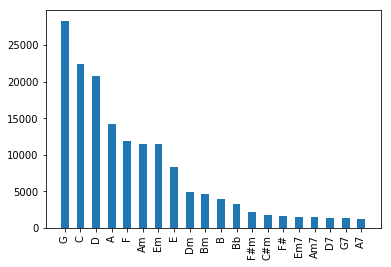

In [56]:
indexes = np.arange(len(chord_names))
width = 0.7
plt.bar(indexes, chord_counts, 0.5)
plt.xticks(indexes, chord_names, rotation="vertical")
plt.show()

In [72]:
df50 = df[df['Year'] == 2018]

In [73]:
chords50 = {}
for idx, row in tqdm(df50.iterrows(), total=df50.shape[0]):
    for chord in row['Chords'].split(','):
        chord = chord.replace("'", '').lstrip().rstrip()
        if chord in chords50 :
            chords50[chord] += 1
        else:
            chords50[chord] = 1

100%|██████████| 46/46 [00:00<00:00, 4436.27it/s]


In [74]:
chords50 = sorted(chords50.items(), key=lambda x: x[1])[::-1]

chord_names50 = [x[0] for x in chords50][:20]
chord_counts50 = [x[1] for x in chords50][:20]

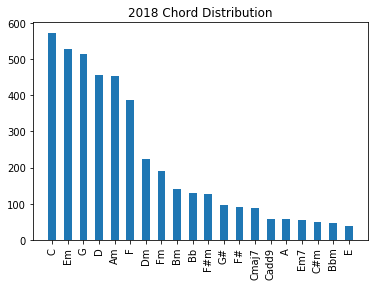

In [76]:
indexes = np.arange(len(chord_names50))
width = 0.7
plt.bar(indexes, chord_counts50, 0.5)
plt.xticks(indexes, chord_names50, rotation="vertical")
plt.title('2018 Chord Distribution')
plt.show()